In [1]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [16]:
%cd '/content/drive/MyDrive/kaggle'

/content/drive/MyDrive/kaggle


In [17]:
df = pd.read_csv("/content/drive/MyDrive/kaggle/Data_path_features.csv")

In [18]:
df

,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a01.wav,-11.113934,-7.215755,-6.219190,-5.926544,-5.850419,-4.808961,-2.513002,-3.500537,-3.721044,-4.487559,-5.429011,-7.305573,-7.141931,-6.555575,-4.516299,-2.556396,-2.251576,-5.133349,-5.566184,-7.205380,-7.909172,-10.862606,-13.266886,-13.715888,-15.576243,-8.864893,-5.869705,-3.969150,-4.066767,-6.243663,-5.814454,-7.329674,-8.715132,-8.864925,-10.491897,-11.772941,-12.314169,...,-25.732899,-21.218548,-17.745354,-15.318403,-13.541670,-13.356754,-13.845391,-13.278706,-13.244025,-13.369603,-13.965578,-12.278998,-12.111441,-11.916994,-11.290673,-10.117015,-8.901153,-7.627750,-8.260026,-7.548607,-7.178619,-6.959355,-5.528706,-4.961089,-4.603842,-4.277052,-4.274704,-3.546704,-3.559063,-3.258881,-4.088853,-5.023864,-5.254714,-5.234093,-5.310308,-5.621666,-6.072196,-6.611347,-2.509089,1.964607
1,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a13.wav,-23.959705,-23.641237,-23.807817,-23.633392,-24.053619,-23.991434,-22.732632,-23.319134,-23.543303,-20.106087,-12.931273,-9.987322,-8.590012,-8.474195,-7.384241,-7.268951,-4.534677,-4.703911,-7.749865,-7.613797,-9.760238,-11.486393,-15.556131,-16.588884,-16.038898,-15.789227,-11.143799,-6.868958,-5.548477,-6.429990,-9.095602,-12.125213,-17.555153,-22.985527,-24.984636,-24.412731,-18.205723,...,-5.105245,-4.775984,-3.447655,-3.556093,-4.517645,-5.738210,-6.771665,-6.776945,-4.989106,-4.555367,-5.801492,-6.535260,-7.198589,-7.033854,-7.685925,-8.138328,-9.260314,-9.036384,-8.342869,-6.564466,-6.376348,-6.304395,-4.836553,-4.045426,-2.990739,-2.041161,-2.524345,-2.121199,-1.452624,-1.697898,-2.394994,-2.839582,-2.200921,-2.065844,-3.630889,-3.178634,-3.635868,-6.033025,-9.823798,-9.753226
2,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a08.wav,-27.551817,-25.248302,-22.912870,-23.200481,-24.561079,-24.916075,-24.402773,-23.608076,-24.458662,-26.309509,-17.455606,-12.566965,-9.477596,-8.501862,-6.108100,-5.471074,-6.081676,-7.459237,-13.114928,-15.257000,-12.997003,-13.713450,-18.609718,-21.843933,-22.382586,-23.097433,-24.328823,-23.972639,-14.147175,-11.284182,-10.598524,-10.438836,-11.025839,-11.915486,-7.537542,-4.022674,-3.923109,...,-7.556040,-6.662713,-5.994764,-6.510767,-8.100865,-6.926768,-7.742791,-11.196093,-15.039673,-17.297121,-19.747395,-20.033142,-20.267086,-21.351856,-22.354635,-22.758381,-23.558012,-23.177013,-22.091814,-21.883476,-20.770206,-20.402622,-23.160770,-23.963894,-23.002195,-22.202248,-22.986452,-23.863976,-23.073124,-24.846188,-24.826651,-24.333981,-24.204630,-24.982929,-24.918049,-26.273071,-26.806255,-27.242727,-26.979715,-27.205202
3,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a07.wav,-25.975302,-22.825100,-21.225157,-20.821096,-19.913891,-20.578136,-22.024477,-20.963707,-14.915606,-11.356565,-8.028171,-7.824315,-6.978572,-6.419868,-6.952181,-6.290453,-6.222239,-6.046099,-6.252188,-6.546420,-7.132365,-7.785093,-6.405703,-5.995083,-6.307068,-7.279632,-6.432416,-6.740263,-6.658838,-6.845708,-5.724951,-5.513878,-4.800431,-6.113788,-5.261055,-6.077095,-5.832385,...,-22.480501,-22.599642,-24.209200,-25.369791,-24.966646,-26.335564,-24.540751,-23.067852,-23.892595,-23.645771,-24.086180,-24.729115,-25.323565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,/content/drive/MyDrive/kaggle/ALL/DC_a05.wav,-22.458635,-22.467833,-25.884357,-27.827045,-27.593534,-26.666508,-18.659025,-11.698080,-10.721752,-11.915209,-6.850739,-3.500977,-4.898458,-9.883922,-11.935939,-12.674129,-13.808365,-13.950251,-1

In [19]:
df.isna().any().sum()

0

In [20]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
4950,-18.611181,-17.616535,-18.411484,-18.987421,-17.404621,-16.747272,-17.733749,-18.055027,-17.931210,-15.913172,-15.003449,-15.979334,-16.348255,-17.795094,-17.092600,-15.416254,-16.268023,-17.509769,-18.500113,-17.777544,-16.064751,-15.990108,-16.825844,-19.416613,-19.248117,-19.206270,-21.032600,-22.249826,-21.765230,-23.090590,-24.427376,-23.955061,-22.673870,-21.966145,-22.520149,-21.388805,-19.803690,-21.663492,-24.595623,-22.753239,...,-24.622999,-23.686852,-23.006695,-23.328550,-22.351040,-22.005341,-23.394726,-23.191683,-21.791996,-21.973999,-22.037476,-22.707808,-22.589994,-25.882610,-22.465931,-20.803608,-20.128231,-21.538298,-23.757799,-22.644869,-21.246086,-22.334455,-24.549614,-22.482368,-21.046780,-19.038082,-19.767479,-22.498535,-21.003120,-22.440336,-22.899403,-21.647814,-19.758650,-18.879402,-19.397379,-20.171659,-22.689241,-24.612816,-24.153774,-22.703135
3860,-13.719338,-16.901081,-23.111773,-21.208946,-22.597612,-27.656578,-25.874819,-24.519142,-25.615971,-25.860441,-25.289042,-26.233866,-29.301311,-25.713509,-25.167057,-24.284536,-20.659727,-20.691711,-17.825060,-17.277483,-17.848997,-17.878527,-18.963680,-20.663626,-21.379459,-22.922880,-24.024254,-26.710335,-28.861376,-30.579754,-29.329121,-28.887737,-29.473236,-31.177673,-30.529715,-27.759480,-24.662609,-23.941545,-25.544828,-25.882589,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9761,-1.533946,-4.030604,-9.614023,-12.045175,-9.992991,-11.926253,-14.008464,-13.561556,-14.024568,-15.151946,-14.091325,-14.444936,-15.080296,-13.436305,-10.627333,-11.366418,-9.941072,-8.282315,-7.593579,-9.596803,-12.209168,-10.878652,-9.996443,-9.153242,-8.455300,-7.230552,-7.610101,-8.270742,-8.250637,-6.913833,-6.073126,-7.495994,-8.007623,-7.892565,-8.418385,-9.888177,-12.714469,-11.961720,-11.708016,-10.882406,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7620,-4.531078,-3.933793,-4.567834,-5.871509,-5.282474,-6.490458,-8.156469,-9.188803,-8.681726,-8.212408,-10.091819,-10.203221,-11.894746,-14.165041,-12.755168,-11.690284,-11.109209,-9.576483,-9.684600,-8.298368,-7.677458,-6.155096,-5.003188,-5.831573,-6.692802,-6.053375,-6.739268,-8.264972,-9.381650,-10.108953,-11.597776,-12.491655,-11.854798,-12.057825,-8.097494,-7.696414,-11.342515,-11.067337,-8.617125,-9.130977,...,-19.450392,-18.572659,-18.351620,-19.521305,-18.855267,-16.842207,-17.038740,-17.506563,-18.298649,-17.981977,-16.775129,-16.381832,-17.170134,-20.650728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11586,-20.621704,-21.587505,-20.563646,-20.703461,-21.205717,-18.608528,-18.446669,-16.211843,-14.257651,-15.160404,-16.223400,-17.730740,-18.256369,-16.877583,-16.413738,-17.221680,-16.712870,-13.694067,-12.639807,-14.987528,-16.563732,-18.237068,-18.482103,-18.212257,-16.454220,-16.483700,-19.338146,-20.670725,-20.005056,-16.037767,-14.584289,-13.579376,-13.083269,-14.677512,-13.112721,-13.186565,-12.656782,-13.191530,-14.0

In [21]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
4950,0.187061,0.303830,0.437761,0.388264,0.497932,0.541479,0.460090,0.431081,0.434383,0.579951,0.642771,0.566986,0.533356,0.422135,0.466129,0.585049,0.517708,0.425094,0.347697,0.399370,0.523183,0.527498,0.462506,0.270701,0.279991,0.283563,0.145378,0.052626,0.083784,-0.016301,-0.118830,-0.084446,0.005868,0.057181,0.011602,0.092895,0.207948,0.063391,-0.171061,-0.032584,...,-1.007438,-0.933479,-0.871044,-0.921475,-0.847683,-0.807560,-0.935576,-0.911144,-0.830915,-0.834381,-0.829219,-0.896774,-0.880639,-1.091292,-0.880570,-0.765047,-0.712700,-0.820002,-0.959708,-0.875309,-0.800564,-0.863728,-0.993725,-0.873860,-0.771624,-0.628735,-0.696994,-0.860163,-0.753168,-0.861100,-0.882224,-0.813218,-0.692869,-0.630748,-0.678032,-0.720307,-0.863235,-0.985900,-0.969144,-0.878309
3860,0.529310,0.355835,0.088777,0.223748,0.113834,-0.265709,-0.140652,-0.045045,-0.131374,-0.152053,-0.114784,-0.188176,-0.418265,-0.160002,-0.127049,-0.065847,0.194944,0.190919,0.397329,0.436171,0.391761,0.388366,0.305087,0.178717,0.122810,0.009231,-0.075418,-0.276586,-0.438801,-0.567948,-0.479871,-0.448339,-0.497108,-0.626413,-0.585694,-0.385727,-0.160704,-0.111361,-0.244741,-0.279203,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
9761,1.381837,1.291359,1.090949,0.902376,1.046133,0.898190,0.734984,0.762056,0.721992,0.635968,0.709951,0.679982,0.626509,0.742579,0.941091,0.882291,0.982700,1.104190,1.149581,1.001410,0.807174,0.904094,0.965385,1.027758,1.075933,1.167520,1.136010,1.084363,1.079046,1.175269,1.233065,1.129772,1.090788,1.101590,1.063210,0.956925,0.745816,0.807625,0.829314,0.902936,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
7620,1.172149,1.298396,1.465616,1.359569,1.394545,1.300389,1.166812,1.084139,1.115335,1.146637,1.004523,0.992349,0.860541,0.689005,0.784772,0.858520,0.896849,1.008946,0.995842,1.096965,1.140966,1.252110,1.333060,1.272774,1.205913,1.254411,1.200281,1.084789,0.995754,0.939918,0.826143,0.761232,0.806198,0.792483,1.087139,1.121589,0.849908,0.876234,1.069238,1.040963,...,-0.636143,-0.568110,-0.541340,-0.651348,-0.600725,-0.446978,-0.490462,-0.515554,-0.589076,-0.559893,-0.469927,-0.465979,-0.513849,-0.739986,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.491118
11586,0.046399,0.015190,0.277969,0.261182,0.216785,0.403764,0.407483,0.566844,0.704832,0.635346,0.552919,0.438009,0.393173,0.489587,0.516001,0.452538,0.485014,0.705911,0.778565,0.604694,0.486430,0.361949,0.340548,0.359538,0.486034,0.484523,0.270435,0.169173,0.213409,0.503205,0.606170,0.680989,0.715323,0.598075,0.713140,0.709120,0.750193,0.713285,0.646436,0.579271,...,0.760025,0.758759,0.758447,0.733704,0.731298,0.729245,0.702776,0.702614,0.677715,0.676531,0.675412,0.649613,0.648145,0.646650,0.624055,0.623299,0.624114,0.605191,0.603481,0.603704,0.586630,0.585692,0.586020,0.572314,0.573280,0.574489,0.554447,0.554641,0.555505,0.539711,0.539434,0.525593,0.525147,0.526374,0.511337,0.511451,0.512173,0.500577,0.495529,0.49

In [22]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(9121, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [23]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(9121, 216, 1)

In [24]:
X_test.shape

(3041, 216, 1)

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.08188096021045708

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [12]:
from tensorflow.keras import optimizers
import tensorflow

In [25]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 216, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 216, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 256)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
571/571 [==============================] - 48s 28ms/step - loss: 2.4749 - accuracy: 0.1777 - val_loss: 2.4950 - val_accuracy: 0.2009
Epoch 2/100
571/571 [==============================] - 15s 27ms/step - loss: 2.2345 - accuracy: 0.2555 - val_loss: 2.2606 - val_accuracy: 0.2736
Epoch 3/100
571/571 [==============================] - 15s 27ms/step - loss: 2.1113 - accuracy: 0.2831 - val_loss: 2.1821 - val_accuracy: 0.3058
Epoch 4/100
571/571 [==============================] - 15s 27ms/step - loss: 2.0180 - accuracy: 0.3132 - val_loss: 2.1187 - val_accuracy: 0.3140
Epoch 5/100
571/571 [==============================] - 15s 27ms/step - loss: 1.9554 - accuracy: 0.3274 - val_loss: 2.0542 - val_accuracy: 0.3282
Epoch 6/100
571/571 [==============================] - 15s 27ms/step - loss: 1.9088 - accuracy: 0.3459 - val_loss: 2.0167 - val_accuracy: 0.3450
Epoch 7/100
571/571 [==============================] - 15s 27ms/step - loss: 1.8677 - accuracy: 0.3672 - val_loss: 1.9863 - val_ac

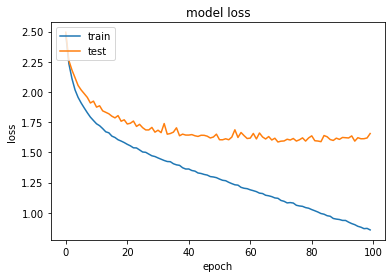

In [27]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/My Drive/kaggle/saved_models/Emotion_Model.h5 


In [31]:
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


accuracy: 42.75%
